* Обучить СНС с помощью Transfer Learning на датасете Food-101
* Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

******************

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from collections import defaultdict
import os
from shutil import copy
from tqdm import tqdm
import imageio
from skimage.transform import resize

In [3]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.6.4
/device:GPU:0


2023-02-05 07:08:39.672768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 07:08:40.076872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 07:08:40.077817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 07:08:40.202053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Load data. Preprocessig

In [4]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

2023-02-05 07:08:43.338991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 07:08:43.339946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 07:08:43.340880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 07:08:43.341669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 07:08:43.342475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=75750, num_sh

In [6]:
# для аугментации 
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in tqdm(classes_images.keys()):
        if not os.path.exists(os.path.join(dest, food)):
            os.makedirs(os.path.join(dest, food))
        for i in classes_images[food]:
            copy(os.path.join(src, food, i), os.path.join(dest, food, i))
    print("Copying Done!")

In [7]:
prepare_data('/kaggle/input/food101/food-101/meta/train.txt', '/kaggle/input/food101/food-101/images', '/kaggle/working/train')

100%|██████████| 101/101 [08:55<00:00,  5.31s/it]

Copying Done!


In [8]:
labels = []
with open('/kaggle/input/food101/food-101/meta/labels.txt', 'r') as f:
    for line in f:
        labels.append(line.rstrip())

In [9]:
labels[:10]

['Apple pie',
 'Baby back ribs',
 'Baklava',
 'Beef carpaccio',
 'Beef tartare',
 'Beet salad',
 'Beignets',
 'Bibimbap',
 'Bread pudding',
 'Breakfast burrito']

2023-02-05 07:17:39.853769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


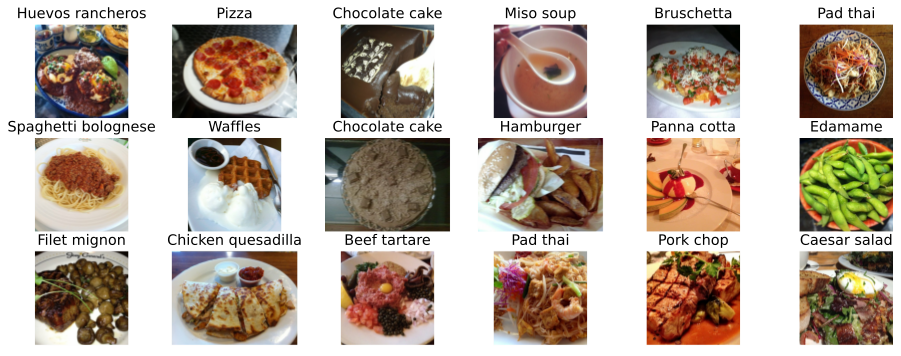

In [10]:
sample = [x for x in iter(train_ds.take(18))]
N = len(sample)
fig = plt.figure(figsize=(16, 8))
for j in range(len(sample)):
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(sample[j][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[sample[j][1]])
    plt.grid(False)
plt.show()

In [11]:
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 32


def prepare(img, label):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)

# Test model function

In [13]:
def model_test(exp: str = 'transfer_trainable_true', augmentation=False):

    if exp == 'scratch' or exp == 'transfer_trainable_false':
        train_param = False
    else:
        train_param = True

    if exp == 'scratch':
        weights = None
    else:
        weights = 'imagenet'

    # **************************************************************************
    base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights=weights
    )
    base_model.trainable = train_param

    # **************************************************************************
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(101, activation='softmax'),
    ])
    # **************************************************************************
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir='logs/'+exp,
        write_graph=False, update_freq=100, profile_batch=0)

    # **************************************************************************
    if augmentation:
        train_generator = datagen.flow_from_directory('/kaggle/working/train',
                                                      target_size=(
                                                          INP_SIZE, INP_SIZE),
                                                      batch_size=16,
                                                      class_mode='sparse')

        history = model.fit(train_generator,
                            epochs=NUM_EPOCHS,
                            validation_data=test_ds,
                            workers=4)

    else:
        history = model.fit(
            train_ds,
            epochs=NUM_EPOCHS,
            validation_data=test_ds,
            callbacks=[tensorboard_callback])

  
    return model

## InceptionResNetV2: FINE-tuning + augmentation

In [ ]:
model_tl = model_test(augmentation=True)

Found 75750 images belonging to 101 classes.
Epoch 1/10


2023-02-05 07:18:15.536063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4735/4735 [==============================] - 1090s 224ms/step - loss: 2.3556 - accuracy: 0.4399 - val_loss: 4.1203 - val_accuracy: 0.6372
Epoch 2/10
4735/4735 [==============================] - 1059s 224ms/step - loss: 1.4432 - accuracy: 0.6349 - val_loss: 1.3137 - val_accuracy: 0.7464
Epoch 3/10
4735/4735 [==============================] - 1037s 219ms/step - loss: 1.1006 - accuracy: 0.7155 - val_loss: 0.8619 - val_accuracy: 0.8128
Epoch 4/10
4735/4735 [==============================] - 1046s 221ms/step - loss: 0.8627 - accuracy: 0.7721 - val_loss: 1.1190 - val_accuracy: 0.8408
Epoch 5/10
4735/4735 [==============================] - 1043s 220ms/step - loss: 0.6938 - accuracy: 0.8129 - val_loss: 1.1875 - val_accuracy: 0.8727
Epoch 6/10
1560/4735 [========>.....................] - ETA: 11:09 - loss: 0.5244 - accuracy: 0.8548

Обучение прервалось из-за недостатка памяти.

In [ ]:
model_tl.summary()

In [ ]:
def prepare_image(img):
    img = img.astype(np.float32)/255.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

In [ ]:
test_img_labels = ['Apple_pie', 'Bibimbap', 'Cannoli', 'Carrot_cake', 'Churros', 'Edamame',
                  'Oysters', 'Paella', 'Pho', 'Prime_rib', 'Ravioli', 'Tuna_tartare']
img_to_show = []
pred_labels = []
for img in test_img_labels:
    img = imageio.imread(os.path.join('test_pred', img.lower()+'.jpg'), pilmode="RGB")
    img_to_show.append(img)
    img = prepare_image(img)
    pred = model_tl(img[None, ...], training=False).numpy()[0]
    pred_labels.append(labels[np.argmax(pred)])

In [ ]:
fig = plt.figure(figsize=(16, 10))
for j in range(len(img_to_show)):
    ax = fig.add_subplot(4, 6, j+1)
    plt.subplots_adjust(wspace=0, hspace=0.5)
    ax.imshow(img_to_show[j])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[sample[j][1]])
    plt.xlabel(f'Predicted: {pred_labels[j]}')
    plt.title(f'True: {test_img_labels[j]}')
    plt.grid(False)
plt.show()

# Вывод:

Модель очень шустро обучается, но памяти на  Kaggle не хватило доделать ноутбук.